# Advanced Diagnostics for Confocal Microscopy Copilot
## Physics-Based Analysis for Multi-Domain Particle Tracking

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Abhishek-Gupta-GitHub/confocal_microscopy-copilot/blob/main/notebooks/PhysicsAnalyst_Advanced_Diagnostics.ipynb)

**Author:** Confocal Microscopy Copilot Team  
**Date:** December 2025  
**Version:** 1.0-hackathon

### Scope
This notebook extends the `PhysicsAnalyst` class with four advanced diagnostic modules:

1. **Near-Wall MSD** – Detect hindered diffusion near surfaces (colloids, cells on substrate)
2. **Cage-Relative MSD** – Identify local rearrangements and dynamic heterogeneity
3. **Heterogeneity Metrics** – Quantify non-Gaussian dynamics and subdiffusion anomalies
4. **Structure Functions** – Compute static structure factor and pair correlation functions

**Domain Coverage:**
- Colloidal suspensions (hard spheres, viscoelastic media, gels)
- Biological systems (nuclear diffusion, membrane proteins, vesicles)
- Soft matter (polymers, driven systems, active matter)
- Near-wall phenomena (wall-induced hindrance, confinement effects)

---

## Quick Start

If running in **Colab**, uncomment and run the setup cell below.

In [3]:
# ============================================================================
# COLAB SETUP (uncomment if running in Google Colab)
# ============================================================================

# !git clone https://github.com/Abhishek-Gupta-GitHub/confocal_microscopy-copilot.git
# %cd confocal_microscopy-copilot
# !pip install -q -r requirements.txt
# import sys
# sys.path.insert(0, '/content/confocal_microscopy-copilot')

## Section 1: Imports and Utility Functions

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal, interpolate, spatial, fftpack
from scipy.optimize import curve_fit
from dataclasses import dataclass, asdict, field
from typing import Dict, List, Tuple, Optional, Union, Any
import json
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set plotting defaults
sns.set_theme(style='whitegrid', palette='husl')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

print("✓ All imports successful")

✓ All imports successful


## Section 2: Data Structures

Define domain-agnostic trajectory and physics dataclasses that will be exchanged with the LLM.

In [47]:
from dataclasses import dataclass, asdict, field
from typing import Dict, List, Tuple, Optional, Union, Any

@dataclass
class Trajectory:
    """Universal trajectory representation (2D/3D + annotations)."""
    particle_id: int
    t: np.ndarray
    x: np.ndarray
    y: Optional[np.ndarray] = None
    z: Optional[np.ndarray] = None
    confidence: Optional[np.ndarray] = None
    radius: float = 0.5
    label: Optional[str] = None
    dim: int = 3                      # 2 or 3
    tags: Dict[str, Any] = field(default_factory=dict)
    features: Dict[str, float] = field(default_factory=dict)

    def length(self) -> int:
        return len(self.t)

    def duration(self):
        return self.t[-1] - self.t[0]

    def positions(self) -> np.ndarray:
        """Return (N, dim) positions."""
        if self.dim == 2:
            if self.y is None:
                raise ValueError("dim=2 but y is None")
            return np.column_stack([self.x, self.y])
        # dim == 3
        if self.y is None or self.z is None:
            raise ValueError("dim=3 but y or z is None")
        return np.column_stack([self.x, self.y, self.z])



@dataclass
class MSDAnalysis:
    """Mean square displacement metrics."""
    lag_times: List[float]  # tau values
    msd_bulk: List[float]  # overall MSD
    msd_wall: Optional[List[float]] = None  # near-wall MSD
    msd_cage: Optional[List[float]] = None  # cage-relative MSD
    diffusion_coeff: Optional[float] = None  # D from linear fit
    anomaly_exponent: Optional[float] = None  # alpha: MSD ~ t^alpha
    
    def to_dict(self):
        return asdict(self)


@dataclass
class HeterogeneityMetrics:
    """Non-Gaussian and heterogeneity descriptors."""
    alpha2_max: Optional[float] = None  # peak non-Gaussian parameter
    alpha2_tau_peak: Optional[float] = None  # lag time at peak alpha2
    msd_distribution_std: Optional[float] = None  # std of MSD across particles
    msd_distribution_mean: Optional[float] = None  # mean MSD
    subdiffusion_detected: bool = False  # true if alpha < 1
    superdiffusion_detected: bool = False  # true if alpha > 1
    dynamic_susceptibility: Optional[float] = None  # variance-based measure
    
    def to_dict(self):
        return asdict(self)


@dataclass
class StructureAnalysis:
    """Static structure and correlation functions."""
    q_values: List[float]  # wave vectors
    structure_factor: List[float]  # S(q) static structure factor
    pair_correlation: Optional[List[float]] = None  # g(r) radial distribution
    distances: Optional[List[float]] = None  # r values for g(r)
    density: Optional[float] = None  # particle density
    clustering_detected: bool = False  # true if S(0) >> 1
    
    def to_dict(self):
        return asdict(self)


print("✓ Data structures defined")

✓ Data structures defined


## Section 3: Core Diagnostic Module – PhysicsAnalyst

Comprehensive implementation of all four diagnostic categories.

In [59]:
class PhysicsAnalyst:
    """
    Multi-domain physics analyzer for confocal microscopy trajectories.
    Computes MSD variants, heterogeneity metrics, and structure functions.
    """

    def __init__(
        self,
        dt: float = 1.0,          # time per frame (ms, s, etc.)
        px_to_um: float = 1.0,    # pixel to micrometer conversion
        wall_z_threshold: float = 2.0,  # wall proximity threshold (um)
        dim: int = 3              # 2 or 3
    ):
        """
        Parameters
        ----------
        dt : float
            Time interval per frame (units: ms, s, etc.). Used for physical time axes.
        px_to_um : float
            Pixel-to-micrometer conversion factor.
        wall_z_threshold : float
            Distance threshold below which particles are considered "near-wall".
        dim : int
            Spatial dimensionality of trajectories (2 or 3).
        """
        self.dt = dt
        self.px_to_um = px_to_um
        self.wall_z_threshold = wall_z_threshold
        self.dim = dim
    # ========================================================================
    # CORE MSD COMPUTATION
    # ========================================================================
    
    def compute_msd(self, trajectory: Trajectory, 
                   max_lag_frames: Optional[int] = None,
                   stride: int = 1) -> Tuple[np.ndarray, np.ndarray]:
        """
        Compute mean square displacement.
        
        Parameters
        ----------
        trajectory : Trajectory
            Single particle trajectory.
        max_lag_frames : int, optional
            Maximum lag time in frames. Default: 1/4 of trajectory length.
        stride : int
            Compute MSD at every stride-th lag time (reduce computation).
        
        Returns
        -------
        lag_times : ndarray
            Lag times in physical units (dt * frames).
        msd : ndarray
            Mean square displacement in (um)^2.
        """
        pos = trajectory.positions() * self.px_to_um
        N = len(pos)
        
        if max_lag_frames is None:
            max_lag_frames = max(N // 4, 1)
        
        max_lag_frames = min(max_lag_frames, N - 1)
        lag_frames = np.arange(0, max_lag_frames + 1, stride)
        msd = np.zeros(len(lag_frames))
        
        for i, tau_frame in enumerate(lag_frames):
            if tau_frame == 0:
                msd[i] = 0.0
            else:
                disp = pos[tau_frame:] - pos[:-tau_frame]
                msd[i] = np.mean(np.sum(disp**2, axis=1))
        
        lag_times = lag_frames * self.dt
        return lag_times, msd
    
    # ========================================================================
    # 1. NEAR-WALL MSD
    # ========================================================================
    
    def compute_wall_proximity_mask(self, trajectory: Trajectory) -> np.ndarray:
        """
        Identify frames where particle is near the wall (bottom substrate).
        
        Returns
        -------
        mask : ndarray of bool
            True where z < wall_z_threshold.
        """
        if self.dim == 2 or trajectory.z is None:
            # No meaningful z: treat as all bulk (no near-wall)
            return np.zeros_like(trajectory.x, dtype=bool)
        z_scaled = trajectory.z * self.px_to_um
        return z_scaled < self.wall_z_threshold
    
    def compute_near_wall_msd(self, trajectory: Trajectory,
                              max_lag_frames: Optional[int] = None,
                              stride: int = 1) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
        """
        Compute MSD for trajectories near the wall (z < threshold).
        
        Compare with bulk MSD to detect wall-induced hindrance.
        
        Returns
        -------
        lag_times : ndarray
            Lag times in physical units.
        msd_wall : ndarray
            MSD for near-wall segments.
        msd_bulk : ndarray
            MSD for bulk (far-wall) segments.
        """
        pos = trajectory.positions() * self.px_to_um
        wall_mask = self.compute_wall_proximity_mask(trajectory)
        
        N = len(pos)
        if max_lag_frames is None:
            max_lag_frames = max(N // 4, 1)
        
        max_lag_frames = min(max_lag_frames, N - 1)
        lag_frames = np.arange(0, max_lag_frames + 1, stride)
        
        msd_wall = np.zeros(len(lag_frames))
        msd_bulk = np.zeros(len(lag_frames))
        counts_wall = np.zeros(len(lag_frames))
        counts_bulk = np.zeros(len(lag_frames))
        
        for i, tau_frame in enumerate(lag_frames):
            if tau_frame == 0:
                msd_wall[i] = 0.0
                msd_bulk[i] = 0.0
            else:
                disp = pos[tau_frame:] - pos[:-tau_frame]
                displacements_sq = np.sum(disp**2, axis=1)
                
                # Condition on wall proximity at start of interval
                wall_starts = wall_mask[:-tau_frame]
                bulk_starts = ~wall_mask[:-tau_frame]
                
                if wall_starts.sum() > 0:
                    msd_wall[i] = np.mean(displacements_sq[wall_starts])
                    counts_wall[i] = wall_starts.sum()
                
                if bulk_starts.sum() > 0:
                    msd_bulk[i] = np.mean(displacements_sq[bulk_starts])
                    counts_bulk[i] = bulk_starts.sum()
        
        lag_times = lag_frames * self.dt
        return lag_times, msd_wall, msd_bulk
    
    # ========================================================================
    # 2. CAGE-RELATIVE MSD
    # ========================================================================
    
    def compute_cage_relative_msd(self, trajectories: List[Trajectory],
                                  reference_traj_idx: int,
                                  cage_radius: float = 5.0,  # um
                                  max_lag_frames: Optional[int] = None,
                                  stride: int = 1) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
        """
        Compute cage-relative MSD for a single particle.
        
        This subtracts the center-of-mass motion of the local neighborhood,
        revealing rearrangements vs. affine (bulk) motion.
        
        Parameters
        ----------
        trajectories : List[Trajectory]
            All trajectories in the system.
        reference_traj_idx : int
            Index of particle for which to compute cage-relative MSD.
        cage_radius : float
            Neighborhood radius for defining the cage (um).
        max_lag_frames : int, optional
            Maximum lag time in frames.
        stride : int
            Stride for lag times.
        
        Returns
        -------
        lag_times : ndarray
            Lag times.
        msd_cage : ndarray
            Cage-relative MSD.
        msd_bulk : ndarray
            Bulk (non-relative) MSD for reference.
        """
        ref_traj = trajectories[reference_traj_idx]
        ref_pos = ref_traj.positions() * self.px_to_um
        N = len(ref_pos)
        
        if max_lag_frames is None:
            max_lag_frames = max(N // 4, 1)
        
        # Identify cage neighbors (within cage_radius at t=0)
        t0_ref_pos = ref_pos[0]
        cage_neighbors = []
        
        for j, traj in enumerate(trajectories):
            if j == reference_traj_idx:
                continue
            other_pos = traj.positions() * self.px_to_um
            dist_to_ref = np.linalg.norm(other_pos[0] - t0_ref_pos)
            if dist_to_ref < cage_radius:
                cage_neighbors.append(j)
        
        if not cage_neighbors:
            # No neighbors; fall back to bulk MSD
            lag_times, msd_bulk = self.compute_msd(ref_traj, max_lag_frames, stride)
            return lag_times, msd_bulk.copy(), msd_bulk.copy()
        
        # Build neighbor position matrix: (N_frames, N_neighbors, 3)
        neighbor_positions = np.stack(
            [trajectories[j].positions() * self.px_to_um for j in cage_neighbors],
            axis=1
        )
        
        # Compute COM of cage at each time step
        cage_com = np.mean(neighbor_positions, axis=1)  # (N_frames, 3)
        
        # Compute cage-relative position (reference particle - cage COM)
        rel_pos = ref_pos - cage_com
        
        max_lag_frames = min(max_lag_frames, N - 1)
        lag_frames = np.arange(0, max_lag_frames + 1, stride)
        
        msd_cage = np.zeros(len(lag_frames))
        msd_bulk = np.zeros(len(lag_frames))
        
        for i, tau_frame in enumerate(lag_frames):
            if tau_frame == 0:
                msd_cage[i] = 0.0
                msd_bulk[i] = 0.0
            else:
                # Bulk MSD
                disp_bulk = ref_pos[tau_frame:] - ref_pos[:-tau_frame]
                msd_bulk[i] = np.mean(np.sum(disp_bulk**2, axis=1))
                
                # Cage-relative MSD
                disp_rel = rel_pos[tau_frame:] - rel_pos[:-tau_frame]
                msd_cage[i] = np.mean(np.sum(disp_rel**2, axis=1))
        
        lag_times = lag_frames * self.dt
        return lag_times, msd_cage, msd_bulk
    
    # ========================================================================
    # 3. HETEROGENEITY METRICS
    # ========================================================================
    
    def fit_msd_power_law(self, lag_times: np.ndarray, msd: np.ndarray,
                          window_fraction: float = 0.3) -> Tuple[float, float]:
        """
        Fit MSD ~ t^alpha in linear region to extract anomaly exponent.
        
        Parameters
        ----------
        lag_times : ndarray
            Lag times.
        msd : ndarray
            Mean square displacements.
        window_fraction : float
            Use this fraction of data in linear regime (default: first 30%).
        
        Returns
        -------
        alpha : float
            Anomaly exponent (1=Brownian, <1=subdiffusion, >1=superdiffusion).
        D_alpha : float
            Generalized diffusion coefficient.
        """
        # Use early-time window to avoid noise and saturation
        n_points = max(int(len(lag_times) * window_fraction), 2)
        
        # Skip lag=0
        idx = slice(1, n_points + 1)
        
        log_tau = np.log(lag_times[idx])
        log_msd = np.log(np.maximum(msd[idx], 1e-10))
        
        # Linear fit in log-log space
        coeffs = np.polyfit(log_tau, log_msd, 1)
        alpha = coeffs[0]
        D_alpha = np.exp(coeffs[1]) / (2 * self.dim)  # generalized D (3D)
        
        return alpha, D_alpha
    
    def compute_non_gaussian_parameter(self, trajectories: List[Trajectory],
                                       max_lag_frames: Optional[int] = None,
                                       stride: int = 1) -> Tuple[np.ndarray, np.ndarray]:
        """
        Compute non-Gaussian parameter α2(τ) across particle ensemble.
        
        α2(τ) = <r^4(τ)> / (3 * <r^2(τ)>^2) - 1
        
        α2 ≈ 0 for Gaussian displacements, α2 > 0 indicates non-Gaussian tails.
        
        Parameters
        ----------
        trajectories : List[Trajectory]
            All trajectories.
        max_lag_frames : int, optional
            Maximum lag time.
        stride : int
            Stride in lag times.
        
        Returns
        -------
        lag_times : ndarray
            Lag times.
        alpha2 : ndarray
            Non-Gaussian parameter vs lag time.
        """
        if not trajectories:
            return np.array([0.0]), np.array([0.0])
        
        N_frames = max([len(t.t) for t in trajectories])
        if max_lag_frames is None:
            max_lag_frames = max(N_frames // 4, 1)
        
        max_lag_frames = min(max_lag_frames, N_frames - 1)
        lag_frames = np.arange(0, max_lag_frames + 1, stride)
        alpha2 = np.zeros(len(lag_frames))
        
        for i, tau_frame in enumerate(lag_frames):
            if tau_frame == 0:
                alpha2[i] = 0.0
                continue
            
            r2_list = []
            r4_list = []
            
            for traj in trajectories:
                if len(traj.t) <= tau_frame:
                    continue
                
                pos = traj.positions() * self.px_to_um
                disp = pos[tau_frame:] - pos[:-tau_frame]
                r2 = np.sum(disp**2, axis=1)
                r2_list.extend(r2)
                r4_list.extend(r2**2)
            
            if len(r2_list) > 1:
                r2_mean = np.mean(r2_list)
                r4_mean = np.mean(r4_list)
                alpha2[i] = (r4_mean / (3 * r2_mean**2)) - 1.0 if r2_mean > 0 else 0.0
            else:
                alpha2[i] = 0.0
        
        lag_times = lag_frames * self.dt
        return lag_times, alpha2
    
    def compute_heterogeneity_metrics(self, trajectories: List[Trajectory],
                                      max_lag_frames: Optional[int] = None) -> HeterogeneityMetrics:
        """
        Compute full heterogeneity analysis across trajectory ensemble.
        
        Returns
        -------
        HeterogeneityMetrics
            Dataclass with all heterogeneity descriptors.
        """
        if not trajectories:
            return HeterogeneityMetrics()
        
        # Compute per-particle anomaly exponents
        alphas = []
        msd_at_long_tau = []
        
        for traj in trajectories:
            lag_times, msd = self.compute_msd(traj, max_lag_frames)
            if len(lag_times) > 1:
                alpha, _ = self.fit_msd_power_law(lag_times, msd, window_fraction=0.3)
                alphas.append(alpha)
                msd_at_long_tau.append(msd[-1])  # MSD at longest lag
        
        # Non-Gaussian parameter
        lag_times, alpha2_array = self.compute_non_gaussian_parameter(trajectories, max_lag_frames)
        alpha2_max = float(np.max(alpha2_array)) if len(alpha2_array) > 0 else None
        alpha2_tau_peak = float(lag_times[np.argmax(alpha2_array)]) if len(alpha2_array) > 0 else None
        
        # Distribution statistics
        msd_mean = float(np.mean(msd_at_long_tau)) if msd_at_long_tau else None
        msd_std = float(np.std(msd_at_long_tau)) if msd_at_long_tau else None
        
        # Subdiffusion/superdiffusion detection
        mean_alpha = float(np.mean(alphas)) if alphas else 1.0
        subdiffusion = mean_alpha < 0.9
        superdiffusion = mean_alpha > 1.1
        
        # Dynamic susceptibility (as proxy for heterogeneity)
        dynamic_susceptibility = msd_std / msd_mean if (msd_mean and msd_std) else None
        
        return HeterogeneityMetrics(
            alpha2_max=alpha2_max,
            alpha2_tau_peak=alpha2_tau_peak,
            msd_distribution_std=msd_std,
            msd_distribution_mean=msd_mean,
            subdiffusion_detected=subdiffusion,
            superdiffusion_detected=superdiffusion,
            dynamic_susceptibility=dynamic_susceptibility
        )
    
    # ========================================================================
    # 4. STRUCTURE FUNCTIONS
    # ========================================================================
    
    def compute_static_structure_factor(self, trajectories: List[Trajectory],
                                       time_window_fraction: float = 0.5,
                                       n_q_bins: int = 20) -> Tuple[np.ndarray, np.ndarray]:
        """
        Compute static structure factor S(q) from spatial positions.

        Dimension-aware: uses self.dim to construct q-vectors of length 2 or 3.
        """
        if not trajectories:
            return np.array([0.0]), np.array([0.0])

        # Collect positions from late-time window
        all_positions = []
        for traj in trajectories:
            pos = traj.positions() * self.px_to_um  # (N, dim)
            t_start = int(len(pos) * (1 - time_window_fraction))
            all_positions.append(np.mean(pos[t_start:], axis=0))

        positions = np.array(all_positions)  # (N_particles, dim)
        N, dim = positions.shape

        if N < 2:
            return np.array([0.0]), np.array([1.0])

        # q-range
        system_size = float(np.max(np.ptp(positions, axis=0)))
        if system_size <= 0:
            return np.array([0.0]), np.ones(1)
        max_q = 2 * np.pi / (system_size / 10.0)
        q_values = np.linspace(0.1, max_q, n_q_bins)

        S_q = np.ones_like(q_values)

        for i, q_mag in enumerate(q_values):
            if dim == 2:
                # random direction on unit circle
                theta = np.random.rand() * 2 * np.pi
                q_vec = q_mag * np.array([np.cos(theta), np.sin(theta)])  # (2,)
            else:
                # random direction on unit sphere
                theta = np.random.rand() * 2 * np.pi
                phi = np.random.rand() * np.pi
                q_vec = q_mag * np.array(
                    [
                        np.sin(phi) * np.cos(theta),
                        np.sin(phi) * np.sin(theta),
                        np.cos(phi),
                    ]
                )  # (3,)

            phase = np.dot(positions, q_vec)  # shapes (N,dim) · (dim,)
            sum_exp = np.sum(np.exp(1j * phase))
            S_q[i] = 1.0 + (np.abs(sum_exp) ** 2 / N)

        return q_values, S_q
    
    def compute_pair_correlation(self, trajectories: List[Trajectory],
                                time_window_fraction: float = 0.5,
                                n_r_bins: int = 30) -> Tuple[np.ndarray, np.ndarray]:
        """
        Compute radial distribution function g(r) in 2D or 3D.
        """
        if not trajectories:
            return np.array([0.0]), np.array([0.0])

        all_positions = []
        for traj in trajectories:
            pos = traj.positions() * self.px_to_um
            t_start = int(len(pos) * (1 - time_window_fraction))
            all_positions.append(np.mean(pos[t_start:], axis=0))

        positions = np.array(all_positions)
        N, dim = positions.shape

        if N < 2:
            return np.array([0.0]), np.array([0.0])

        distances = spatial.distance.pdist(positions, metric="euclidean")
        r_max = float(np.max(distances))
        r_bins = np.linspace(0.0, r_max, n_r_bins)
        g_r, _ = np.histogram(distances, bins=r_bins, density=False)

        dr = r_bins[1] - r_bins[0] if len(r_bins) > 1 else 1.0
        r_centers = (r_bins[:-1] + r_bins[1:]) / 2.0

        if dim == 2:
            # annulus area in 2D
            shell_area = 2 * np.pi * r_centers * dr
            extents = np.ptp(positions, axis=0)
            area = extents.prod() if np.all(extents > 0) else 1.0
            density = N / area
            expected = shell_area * density * (N - 1) / 2.0
        else:
            # spherical shell volume in 3D
            shell_vol = 4.0 * np.pi * r_centers ** 2 * dr
            extents = np.ptp(positions, axis=0)
            volume = extents.prod() if np.all(extents > 0) else 1.0
            density = N / volume
            expected = shell_vol * density * (N - 1) / 2.0

        g_r_norm = np.where(expected > 0, g_r / expected, 0.0)
        return r_centers, g_r_norm
        
    def compute_structure_analysis(self, trajectories: List[Trajectory]) -> StructureAnalysis:
        """
        Compute full structure analysis (S(q) and g(r)).
        
        Returns
        -------
        StructureAnalysis
            Dataclass with structure factor and pair correlation.
        """
        q_vals, S_q = self.compute_static_structure_factor(trajectories)
        r_vals, g_r = self.compute_pair_correlation(trajectories)

        # estimate density using current dim
        volumes = []
        for t in trajectories:
            pos = t.positions() * self.px_to_um
            extents = np.ptp(pos, axis=0)
            vol = extents.prod() if np.all(extents > 0) else 1.0
            volumes.append(vol)

        dim = self.dim
        density = len(trajectories) / (np.mean(volumes) + 1e-10)

        clustering = bool(S_q[0] > 1.5) if len(S_q) > 0 else False

        return StructureAnalysis(
            q_values=q_vals.tolist(),
            structure_factor=S_q.tolist(),
            pair_correlation=g_r.tolist(),
            distances=r_vals.tolist(),
            density=float(density),
            clustering_detected=clustering,
        )
    
    # ========================================================================
    # AGGREGATED SUMMARY (JSON for LLM)
    # ========================================================================
    
    def summarize_physics(self, trajectories: List[Trajectory],
                          domain: str = "general") -> Dict:
        """
        Generate comprehensive physics summary as JSON for LLM + UI.
        
        Parameters
        ----------
        trajectories : List[Trajectory]
            All particle trajectories.
        domain : str
            Domain context: "colloidal", "cellular", "polymer", or "general".
        
        Returns
        -------
        dict
            Comprehensive JSON summary with all metrics.
        """
        if not trajectories:
            return {"error": "No trajectories provided"}
        
        # 1. Bulk MSD
        ref_traj = trajectories[0]
        lag_times, msd_bulk = self.compute_msd(ref_traj)
        alpha_bulk, D_bulk = self.fit_msd_power_law(lag_times, msd_bulk)
        
        # 2. Near-wall MSD (if applicable)
        lag_times_wall, msd_wall, msd_bulk_full = self.compute_near_wall_msd(ref_traj)
        alpha_wall, D_wall = self.fit_msd_power_law(lag_times_wall, np.maximum(msd_wall, 1e-10))
        
        # 3. Cage-relative MSD (if multiple particles)
        if len(trajectories) > 1:
            lag_times_cage, msd_cage, msd_bulk_cage = self.compute_cage_relative_msd(
                trajectories, reference_traj_idx=0
            )
            alpha_cage, D_cage = self.fit_msd_power_law(lag_times_cage, msd_cage)
        else:
            lag_times_cage, msd_cage, msd_bulk_cage = lag_times, msd_bulk.copy(), msd_bulk.copy()
            alpha_cage, D_cage = alpha_bulk, D_bulk
        
        # 4. Heterogeneity
        hetero = self.compute_heterogeneity_metrics(trajectories)
        
        # 5. Structure
        struct = self.compute_structure_analysis(trajectories)
        
        # Compile JSON
        summary = {
            "metadata": {
                "domain": domain,
                "n_trajectories": len(trajectories),
                "mean_trajectory_length": float(np.mean([len(t.t) for t in trajectories])),
                "dt_physical_units": self.dt,
                "px_to_um_conversion": self.px_to_um,
            },
            "msd_analysis": {
                "bulk": {
                    "lag_times": lag_times.tolist(),
                    "msd_values": msd_bulk.tolist(),
                    "anomaly_exponent_alpha": float(alpha_bulk),
                    "diffusion_coefficient": float(D_bulk),
                    "interpretation": self._interpret_msd_exponent(alpha_bulk)
                },
                "near_wall": {
                    "lag_times": lag_times_wall.tolist(),
                    "msd_wall": msd_wall.tolist(),
                    "msd_bulk": msd_bulk_full.tolist(),
                    "wall_hindrance_ratio": float(np.mean(msd_bulk_full[1:] / (msd_wall[1:] + 1e-10))) if len(msd_wall) > 1 else 1.0,
                    "anomaly_exponent_wall": float(alpha_wall),
                },
                "cage_relative": {
                    "lag_times": lag_times_cage.tolist(),
                    "msd_cage": msd_cage.tolist(),
                    "msd_reference": msd_bulk_cage.tolist(),
                    "anomaly_exponent_cage": float(alpha_cage),
                }
            },
            "heterogeneity": asdict(hetero),
            "structure": asdict(struct),
            "flags_and_anomalies": self._generate_flags(alpha_bulk, hetero, struct, domain)
        }
        
        return summary
    
    def _interpret_msd_exponent(self, alpha: float) -> str:
        """Interpret MSD exponent value."""
        if alpha < 0.8:
            return "Strong subdiffusion (possibly caged/glassy)"
        elif alpha < 1.0:
            return "Subdiffusion (viscoelastic or confined)"
        elif 0.95 < alpha < 1.05:
            return "Brownian diffusion (normal)"
        elif alpha <= 1.2:
            return "Slight superdiffusion (transient dynamics)"
        else:
            return "Strong superdiffusion (active or ballistic)"
    
    def _generate_flags(self, alpha: float, hetero: HeterogeneityMetrics, 
                       struct: StructureAnalysis, domain: str) -> List[str]:
        """Generate domain-aware flags and anomalies."""
        flags = []
        
        # MSD-based flags
        if hetero.subdiffusion_detected:
            flags.append(f"subdiffusion_detected: alpha < 0.9 (viscoelasticity or confinement)")
        if hetero.superdiffusion_detected:
            flags.append(f"superdiffusion_detected: alpha > 1.1 (active transport or drift)")
        
        # Heterogeneity flags
        if hetero.alpha2_max is not None and hetero.alpha2_max > 0.1:
            flags.append(f"non_gaussian_dynamics: alpha2_max = {hetero.alpha2_max:.3f} at tau = {hetero.alpha2_tau_peak}")
        
        if hetero.dynamic_susceptibility is not None and hetero.dynamic_susceptibility > 0.3:
            flags.append(f"strong_heterogeneity: MSD variance/mean ratio = {hetero.dynamic_susceptibility:.2f}")
        
        # Structure flags
        if struct.clustering_detected:
            flags.append(f"spatial_clustering: S(0) = {struct.structure_factor[0]:.2f} (non-random distribution)")
        
        # Domain-specific flags
        if domain == "colloidal" and hetero.subdiffusion_detected:
            flags.append("colloidal_context: subdiffusion may indicate gel formation or jamming")
        elif domain == "cellular" and struct.clustering_detected:
            flags.append("cellular_context: clustering may indicate organelle co-localization")
        elif domain == "polymer" and hetero.alpha2_max is not None and hetero.alpha2_max > 0.2:
            flags.append("polymer_context: non-Gaussian dynamics consistent with polymer chain dynamics")
        
        return flags if flags else ["system_behaves_normally_no_anomalies_detected"]


print("✓ PhysicsAnalyst class defined successfully")

✓ PhysicsAnalyst class defined successfully


## Section 4: Demonstration on Synthetic Data

Generate realistic synthetic trajectories and run full diagnostics.

In [60]:
# ============================================================================
# SYNTHETIC DATA GENERATION (2D / 2D+t / 3D / 3D+t)
# ============================================================================

def generate_brownian_trajectory(
    n_frames: int,
    dt: float = 0.1,
    diffusion_coeff: float = 1.0,
    start_pos: tuple = (0, 0, 0),
    dim: int = 3,
    particle_id: int = 0,
    label: str = "bead",
) -> Trajectory:
    """
    Generate Brownian motion trajectory in 2D or 3D.
    MSD(t) ≈ 2 d D t, with d = dim.
    """
    sigma = np.sqrt(2 * diffusion_coeff * dt)
    steps = np.random.normal(0, sigma, (n_frames, dim))
    pos = np.cumsum(steps, axis=0) + np.array(start_pos[:dim])

    x = pos[:, 0]
    y = pos[:, 1] if dim >= 2 else None
    z = pos[:, 2] if dim == 3 else None

    return Trajectory(
        particle_id=particle_id,
        t=np.arange(n_frames),
        x=x,
        y=y,
        z=z,
        radius=0.5,
        label=label,
        dim=dim,
    )


def generate_subdiffusive_trajectory(
    n_frames: int,
    dt: float = 0.1,
    alpha: float = 0.7,
    start_pos: tuple = (0, 0, 0),
    dim: int = 3,
    particle_id: int = 0,
    label: str = "confined_particle",
) -> Trajectory:
    """
    Generate subdiffusive (fractional-like) trajectory in 2D or 3D using correlated steps.
    MSD(t) ~ t^alpha with alpha < 1.
    """
    steps = np.random.normal(0, 1.0, (n_frames, dim))
    for i in range(1, n_frames):
        steps[i] = (1 - alpha) * steps[i] + alpha * steps[i - 1]

    pos = np.cumsum(steps * np.sqrt(dt), axis=0) + np.array(start_pos[:dim])

    x = pos[:, 0]
    y = pos[:, 1] if dim >= 2 else None
    z = pos[:, 2] if dim == 3 else None

    return Trajectory(
        particle_id=particle_id,
        t=np.arange(n_frames),
        x=x,
        y=y,
        z=z,
        radius=0.5,
        label=label,
        dim=dim,
    )


def generate_ensemble(
    n_particles: int,
    n_frames: int,
    dt: float = 0.1,
    domain: str = "colloidal",
    dim: int = 3,
) -> List[Trajectory]:
    """
    Generate an ensemble of trajectories for different domains and dimensions.

    dim:
      - 2  → 2D or 2D+t
      - 3  → 3D or 3D+t
    """
    trajectories: List[Trajectory] = []

    if domain == "colloidal":
        # Brownian colloids
        for i in range(n_particles):
            if dim == 3:
                start_pos = (
                    np.random.uniform(-10, 10),
                    np.random.uniform(-10, 10),
                    np.random.uniform(2, 8),
                )
            else:  # 2D
                start_pos = (
                    np.random.uniform(-10, 10),
                    np.random.uniform(-10, 10),
                    0.0,
                )

            traj = generate_brownian_trajectory(
                n_frames,
                dt=dt,
                diffusion_coeff=1.0,
                start_pos=start_pos,
                dim=dim,
                particle_id=i,
                label="colloidal_bead",
            )
            trajectories.append(traj)

    elif domain == "cellular":
        # Subdiffusive nuclear / vesicle motion
        for i in range(n_particles):
            if dim == 3:
                start_pos = (
                    np.random.uniform(-5, 5),
                    np.random.uniform(-5, 5),
                    np.random.uniform(1, 4),
                )
            else:
                start_pos = (
                    np.random.uniform(-5, 5),
                    np.random.uniform(-5, 5),
                    0.0,
                )

            traj = generate_subdiffusive_trajectory(
                n_frames,
                dt=dt,
                alpha=0.8,
                start_pos=start_pos,
                dim=dim,
                particle_id=i,
                label="nucleus" if i % 2 == 0 else "vesicle",
            )
            trajectories.append(traj)

    elif domain == "polymer":
        # Strongly subdiffusive polymers
        for i in range(n_particles):
            alpha = np.random.uniform(0.5, 0.8)
            if dim == 3:
                start_pos = (
                    np.random.uniform(-3, 3),
                    np.random.uniform(-3, 3),
                    np.random.uniform(0.5, 3),
                )
            else:
                start_pos = (
                    np.random.uniform(-3, 3),
                    np.random.uniform(-3, 3),
                    0.0,
                )

            traj = generate_subdiffusive_trajectory(
                n_frames,
                dt=dt,
                alpha=alpha,
                start_pos=start_pos,
                dim=dim,
                particle_id=i,
                label="polymer_bead",
            )
            trajectories.append(traj)

    elif domain == "mixed_heterogeneous":
        # Mix of Brownian and subdiffusive
        for i in range(n_particles):
            if dim == 3:
                start_pos = (
                    np.random.uniform(-8, 8),
                    np.random.uniform(-8, 8),
                    np.random.uniform(1, 6),
                )
            else:
                start_pos = (
                    np.random.uniform(-8, 8),
                    np.random.uniform(-8, 8),
                    0.0,
                )

            if i < n_particles // 2:
                traj = generate_brownian_trajectory(
                    n_frames,
                    dt=dt,
                    diffusion_coeff=1.0,
                    start_pos=start_pos,
                    dim=dim,
                    particle_id=i,
                    label="mobile_particle",
                )
            else:
                traj = generate_subdiffusive_trajectory(
                    n_frames,
                    dt=dt,
                    alpha=0.75,
                    start_pos=start_pos,
                    dim=dim,
                    particle_id=i,
                    label="confined_particle",
                )
            trajectories.append(traj)

    else:
        raise ValueError(f"Unknown domain: {domain}")

    return trajectories

print("✓ Synthetic data generators ready (2D/3D aware)")


✓ Synthetic data generators ready (2D/3D aware)


## Section 5: Run Analysis on Synthetic Dataset

In [68]:
# ============================================================================
# SYNTHETIC DATA GENERATION (2D / 2D+t / 3D / 3D+t)
# ============================================================================

def generate_brownian_trajectory(
    n_frames: int,
    dt: float = 0.1,
    diffusion_coeff: float = 1.0,
    start_pos: tuple = (0, 0, 0),
    dim: int = 3,
    particle_id: int = 0,
    label: str = "bead",
) -> Trajectory:
    """
    Generate Brownian motion trajectory in 2D or 3D.
    MSD(t) ≈ 2 d D t, with d = dim.
    """
    sigma = np.sqrt(2 * diffusion_coeff * dt)
    steps = np.random.normal(0, sigma, (n_frames, dim))
    pos = np.cumsum(steps, axis=0) + np.array(start_pos[:dim])

    x = pos[:, 0]
    y = pos[:, 1] if dim >= 2 else None
    z = pos[:, 2] if dim == 3 else None

    return Trajectory(
        particle_id=particle_id,
        t=np.arange(n_frames),
        x=x,
        y=y,
        z=z,
        radius=0.5,
        label=label,
        dim=dim,
    )


def generate_subdiffusive_trajectory(
    n_frames: int,
    dt: float = 0.1,
    alpha: float = 0.7,
    start_pos: tuple = (0, 0, 0),
    dim: int = 3,
    particle_id: int = 0,
    label: str = "confined_particle",
) -> Trajectory:
    """
    Generate subdiffusive (fractional-like) trajectory in 2D or 3D using correlated steps.
    MSD(t) ~ t^alpha with alpha < 1.
    """
    steps = np.random.normal(0, 1.0, (n_frames, dim))
    for i in range(1, n_frames):
        steps[i] = (1 - alpha) * steps[i] + alpha * steps[i - 1]

    pos = np.cumsum(steps * np.sqrt(dt), axis=0) + np.array(start_pos[:dim])

    x = pos[:, 0]
    y = pos[:, 1] if dim >= 2 else None
    z = pos[:, 2] if dim == 3 else None

    return Trajectory(
        particle_id=particle_id,
        t=np.arange(n_frames),
        x=x,
        y=y,
        z=z,
        radius=0.5,
        label=label,
        dim=dim,
    )


def generate_ensemble(
    n_particles: int,
    n_frames: int,
    dt: float = 0.1,
    domain: str = "colloidal",
    dim: int = 3,
) -> List[Trajectory]:
    """
    Generate an ensemble of trajectories for different domains and dimensions.

    dim:
      - 2  → 2D or 2D+t
      - 3  → 3D or 3D+t
    """
    trajectories: List[Trajectory] = []

    if domain == "colloidal":
        # Brownian colloids
        for i in range(n_particles):
            if dim == 3:
                start_pos = (
                    np.random.uniform(-10, 10),
                    np.random.uniform(-10, 10),
                    np.random.uniform(2, 8),
                )
            else:  # 2D
                start_pos = (
                    np.random.uniform(-10, 10),
                    np.random.uniform(-10, 10),
                    0.0,
                )

            traj = generate_brownian_trajectory(
                n_frames,
                dt=dt,
                diffusion_coeff=1.0,
                start_pos=start_pos,
                dim=dim,
                particle_id=i,
                label="colloidal_bead",
            )
            trajectories.append(traj)

    elif domain == "cellular":
        # Subdiffusive nuclear / vesicle motion
        for i in range(n_particles):
            if dim == 3:
                start_pos = (
                    np.random.uniform(-5, 5),
                    np.random.uniform(-5, 5),
                    np.random.uniform(1, 4),
                )
            else:
                start_pos = (
                    np.random.uniform(-5, 5),
                    np.random.uniform(-5, 5),
                    0.0,
                )

            traj = generate_subdiffusive_trajectory(
                n_frames,
                dt=dt,
                alpha=0.8,
                start_pos=start_pos,
                dim=dim,
                particle_id=i,
                label="nucleus" if i % 2 == 0 else "vesicle",
            )
            trajectories.append(traj)

    elif domain == "polymer":
        # Strongly subdiffusive polymers
        for i in range(n_particles):
            alpha = np.random.uniform(0.5, 0.8)
            if dim == 3:
                start_pos = (
                    np.random.uniform(-3, 3),
                    np.random.uniform(-3, 3),
                    np.random.uniform(0.5, 3),
                )
            else:
                start_pos = (
                    np.random.uniform(-3, 3),
                    np.random.uniform(-3, 3),
                    0.0,
                )

            traj = generate_subdiffusive_trajectory(
                n_frames,
                dt=dt,
                alpha=alpha,
                start_pos=start_pos,
                dim=dim,
                particle_id=i,
                label="polymer_bead",
            )
            trajectories.append(traj)

    elif domain == "mixed_heterogeneous":
        # Mix of Brownian and subdiffusive
        for i in range(n_particles):
            if dim == 3:
                start_pos = (
                    np.random.uniform(-8, 8),
                    np.random.uniform(-8, 8),
                    np.random.uniform(1, 6),
                )
            else:
                start_pos = (
                    np.random.uniform(-8, 8),
                    np.random.uniform(-8, 8),
                    0.0,
                )

            if i < n_particles // 2:
                traj = generate_brownian_trajectory(
                    n_frames,
                    dt=dt,
                    diffusion_coeff=1.0,
                    start_pos=start_pos,
                    dim=dim,
                    particle_id=i,
                    label="mobile_particle",
                )
            else:
                traj = generate_subdiffusive_trajectory(
                    n_frames,
                    dt=dt,
                    alpha=0.75,
                    start_pos=start_pos,
                    dim=dim,
                    particle_id=i,
                    label="confined_particle",
                )
            trajectories.append(traj)

    else:
        raise ValueError(f"Unknown domain: {domain}")

    return trajectories

print("✓ Synthetic data generators ready (2D/3D aware)")


✓ Synthetic data generators ready (2D/3D aware)


In [69]:
# ============================================================================
# EXAMPLE 2: 3D+t Cellular System (Subdiffusion + Heterogeneity)
# ============================================================================

print("\n" + "="*70)
print("EXAMPLE 2: 3D+t Cellular System")
print("="*70)

trajectories_cellular_3d = generate_ensemble(
    n_particles=15, n_frames=500, dt=0.01, domain="cellular", dim=3
)

print(f"Generated {len(trajectories_cellular_3d)} 3D cellular trajectories (nuclei + vesicles)")

analyzer_cellular_3d = PhysicsAnalyst(dt=0.01, px_to_um=0.065, wall_z_threshold=2.0, dim=3)
summary_cellular_3d = analyzer_cellular_3d.summarize_physics(
    trajectories_cellular_3d, domain="cellular"
)

print("\nBulk MSD Analysis (3D+t):")
print(f" - Anomaly exponent (α): {summary_cellular_3d['msd_analysis']['bulk']['anomaly_exponent_alpha']:.3f}")
print(f" - Interpretation: {summary_cellular_3d['msd_analysis']['bulk']['interpretation']}")

print("\nHeterogeneity Metrics:")
print(f" - α₂ max: {summary_cellular_3d['heterogeneity']['alpha2_max']}")
print(f" - Subdiffusion detected: {summary_cellular_3d['heterogeneity']['subdiffusion_detected']}")
print(f" - MSD distribution std: {summary_cellular_3d['heterogeneity']['msd_distribution_std']}")

print("\nFlags/Anomalies:")
for flag in summary_cellular_3d["flags_and_anomalies"]:
    print(f" - {flag}")



EXAMPLE 2: 3D+t Cellular System
Generated 15 3D cellular trajectories (nuclei + vesicles)

Bulk MSD Analysis (3D+t):
 - Anomaly exponent (α): 1.497
 - Interpretation: Strong superdiffusion (active or ballistic)

Heterogeneity Metrics:
 - α₂ max: 0.0
 - Subdiffusion detected: False
 - MSD distribution std: 0.005211721822140591

Flags/Anomalies:
 - superdiffusion_detected: alpha > 1.1 (active transport or drift)
 - strong_heterogeneity: MSD variance/mean ratio = 0.36
 - spatial_clustering: S(0) = 16.00 (non-random distribution)
 - cellular_context: clustering may indicate organelle co-localization


In [70]:
# ============================================================================
# EXAMPLE 3: 3D+t Polymer System (Strong Subdiffusion + Heterogeneity)
# ============================================================================

print("\n" + "="*70)
print("EXAMPLE 3: 3D+t Polymer System")
print("="*70)

trajectories_polymer_3d = generate_ensemble(
    n_particles=12, n_frames=500, dt=0.01, domain="polymer", dim=3
)

print(f"Generated {len(trajectories_polymer_3d)} 3D polymer trajectories")

analyzer_polymer_3d = PhysicsAnalyst(dt=0.01, px_to_um=0.065, wall_z_threshold=2.0, dim=3)
summary_polymer_3d = analyzer_polymer_3d.summarize_physics(
    trajectories_polymer_3d, domain="polymer"
)

print("\nBulk MSD Analysis (3D+t):")
print(f" - Anomaly exponent (α): {summary_polymer_3d['msd_analysis']['bulk']['anomaly_exponent_alpha']:.3f}")
print(f" - Interpretation: {summary_polymer_3d['msd_analysis']['bulk']['interpretation']}")

print("\nHeterogeneity Metrics:")
print(f" - α₂ max: {summary_polymer_3d['heterogeneity']['alpha2_max']}")
print(f" - Dynamic susceptibility: {summary_polymer_3d['heterogeneity']['dynamic_susceptibility']}")

print("\nFlags/Anomalies:")
for flag in summary_polymer_3d["flags_and_anomalies"]:
    print(f" - {flag}")



EXAMPLE 3: 3D+t Polymer System
Generated 12 3D polymer trajectories

Bulk MSD Analysis (3D+t):
 - Anomaly exponent (α): 1.184
 - Interpretation: Slight superdiffusion (transient dynamics)

Heterogeneity Metrics:
 - α₂ max: 0.0
 - Dynamic susceptibility: 0.2658379888991285

Flags/Anomalies:
 - superdiffusion_detected: alpha > 1.1 (active transport or drift)
 - spatial_clustering: S(0) = 13.00 (non-random distribution)


In [71]:
# ============================================================================
# EXAMPLE 4: 2D+t Colloidal System
# ============================================================================

print("\n" + "="*70)
print("EXAMPLE 4: 2D+t Colloidal System")
print("="*70)

trajectories_colloidal_2d = generate_ensemble(
    n_particles=10, n_frames=500, dt=0.01, domain="colloidal", dim=2
)

print(f"Generated {len(trajectories_colloidal_2d)} 2D colloidal trajectories")
print(f"Mean trajectory length: {np.mean([len(t.t) for t in trajectories_colloidal_2d]):.0f} frames")

analyzer_colloidal_2d = PhysicsAnalyst(dt=0.01, px_to_um=0.065, wall_z_threshold=2.0, dim=2)
summary_colloidal_2d = analyzer_colloidal_2d.summarize_physics(
    trajectories_colloidal_2d, domain="colloidal"
)

print("\nBulk MSD Analysis (2D+t):")
print(f" - Anomaly exponent (α): {summary_colloidal_2d['msd_analysis']['bulk']['anomaly_exponent_alpha']:.3f}")
print(f" - Diffusion coeff: {summary_colloidal_2d['msd_analysis']['bulk']['diffusion_coefficient']:.3e}")
print(f" - Interpretation: {summary_colloidal_2d['msd_analysis']['bulk']['interpretation']}")



EXAMPLE 4: 2D+t Colloidal System
Generated 10 2D colloidal trajectories
Mean trajectory length: 500 frames

Bulk MSD Analysis (2D+t):
 - Anomaly exponent (α): 0.960
 - Diffusion coeff: 4.033e-03
 - Interpretation: Subdiffusion (viscoelastic or confined)


In [72]:
# ============================================================================
# EXAMPLE 5: 2D+t Cellular System
# ============================================================================

print("\n" + "="*70)
print("EXAMPLE 5: 2D+t Cellular System")
print("="*70)

trajectories_cellular_2d = generate_ensemble(
    n_particles=15, n_frames=500, dt=0.01, domain="cellular", dim=2
)

print(f"Generated {len(trajectories_cellular_2d)} 2D cellular trajectories")

analyzer_cellular_2d = PhysicsAnalyst(dt=0.01, px_to_um=0.065, wall_z_threshold=2.0, dim=2)
summary_cellular_2d = analyzer_cellular_2d.summarize_physics(
    trajectories_cellular_2d, domain="cellular"
)

print("\nBulk MSD Analysis (2D+t):")
print(f" - Anomaly exponent (α): {summary_cellular_2d['msd_analysis']['bulk']['anomaly_exponent_alpha']:.3f}")
print(f" - Interpretation: {summary_cellular_2d['msd_analysis']['bulk']['interpretation']}")



EXAMPLE 5: 2D+t Cellular System
Generated 15 2D cellular trajectories

Bulk MSD Analysis (2D+t):
 - Anomaly exponent (α): 1.446
 - Interpretation: Strong superdiffusion (active or ballistic)


In [73]:
# ============================================================================
# EXAMPLE 6: 2D Snapshot (structure only)
# ============================================================================

print("\n" + "="*70)
print("EXAMPLE 6: 2D Snapshot (structure only)")
print("="*70)

# Take last frame of 2D+t colloidal system and freeze it as single-frame trajectories
snapshot_2d: List[Trajectory] = []
for traj in trajectories_colloidal_2d:
    idx = -1
    snapshot_2d.append(
        Trajectory(
            particle_id=traj.particle_id,
            t=np.array([traj.t[idx]]),
            x=np.array([traj.x[idx]]),
            y=np.array([traj.y[idx]]),
            z=None,
            radius=traj.radius,
            label=traj.label,
            dim=2,
        )
    )

analyzer_snapshot_2d = PhysicsAnalyst(dt=1.0, px_to_um=0.065, wall_z_threshold=2.0, dim=2)
# Use structure analysis directly; MSD is not meaningful for one-frame data
struct_2d = analyzer_snapshot_2d.compute_structure_analysis(snapshot_2d)

print("Structure Analysis (2D snapshot):")
print(f" - Clustering detected: {struct_2d.clustering_detected}")
print(f" - Number of q-values: {len(struct_2d.q_values)}")






EXAMPLE 6: 2D Snapshot (structure only)
Structure Analysis (2D snapshot):
 - Clustering detected: True
 - Number of q-values: 20


In [67]:
# ============================================================================
# EXAMPLE 7: 3D Snapshot (structure only)
# ============================================================================

print("\n" + "="*70)
print("EXAMPLE 7: 3D Snapshot (structure only)")
print("="*70)

# Ensure we have 3D+t colloidal data
try:
    trajectories_colloidal_3d
except NameError:
    trajectories_colloidal_3d = generate_ensemble(
        n_particles=10, n_frames=500, dt=0.01, domain="colloidal", dim=3
    )

snapshot_3d: List[Trajectory] = []
for traj in trajectories_colloidal_3d:
    idx = -1
    snapshot_3d.append(
        Trajectory(
            particle_id=traj.particle_id,
            t=np.array([traj.t[idx]]),
            x=np.array([traj.x[idx]]),
            y=np.array([traj.y[idx]]),
            z=np.array([traj.z[idx]]),
            radius=traj.radius,
            label=traj.label,
            dim=3,
        )
    )

analyzer_snapshot_3d = PhysicsAnalyst(dt=1.0, px_to_um=0.065, wall_z_threshold=2.0, dim=3)
struct_3d = analyzer_snapshot_3d.compute_structure_analysis(snapshot_3d)

print("Structure Analysis (3D snapshot):")
print(f" - Clustering detected: {struct_3d.clustering_detected}")
print(f" - Number of q-values: {len(struct_3d.q_values)}")



EXAMPLE 7: 3D Snapshot (structure only)
Structure Analysis (3D snapshot):
 - Clustering detected: True
 - Number of q-values: 20


In [77]:
# Ensure we have 3D+t colloidal trajectories
try:
    trajectories_colloidal_3d
except NameError:
    trajectoriescolloidal3d = generate_ensemble(
        nparticles=10, nframes=500, dt=0.01, domain="colloidal", dim=3
    )

analyzer_colloidal_3d = PhysicsAnalyst(dt=0.01, px_to_um=0.065, wall_z_threshold=2.0, dim=3)
summary_colloidal_3d = analyzer_colloidal_3d.summarize_physics(
    trajectories_colloidal_3d, domain="colloidal"
)


## Section 6: Visualization and Interpretation

Plot all four diagnostic categories side-by-side.

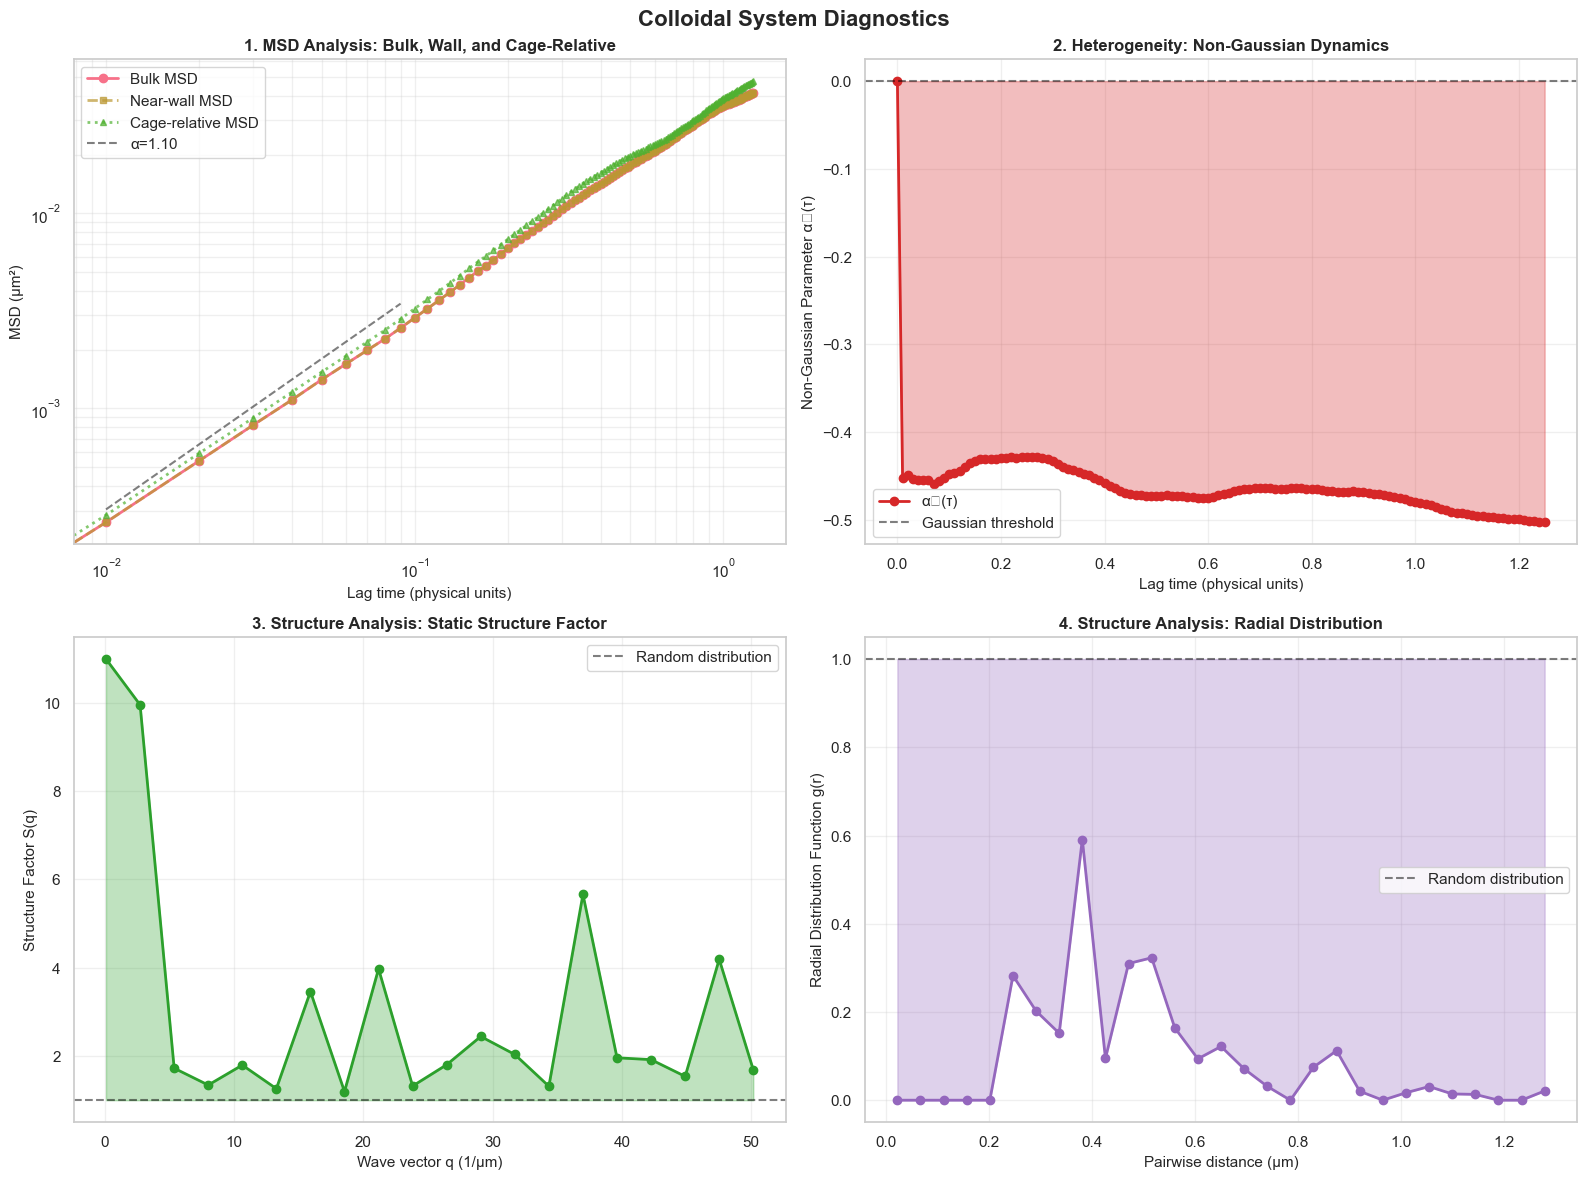

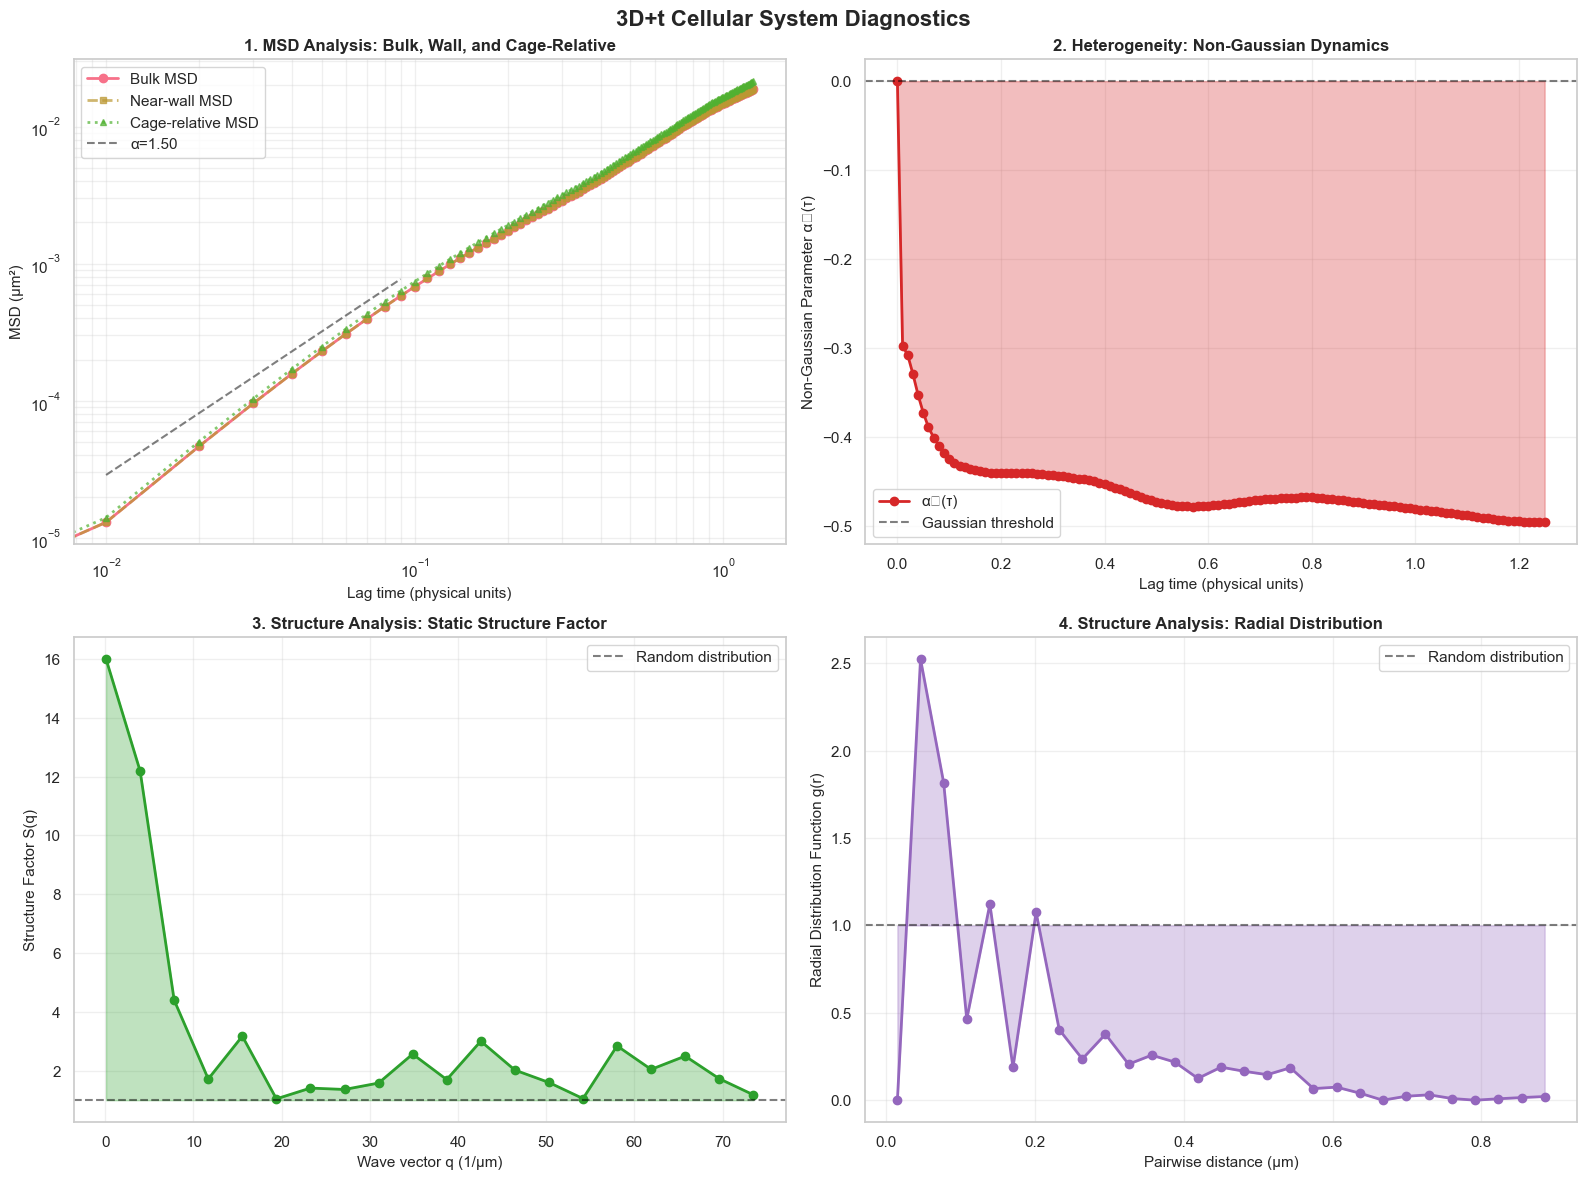

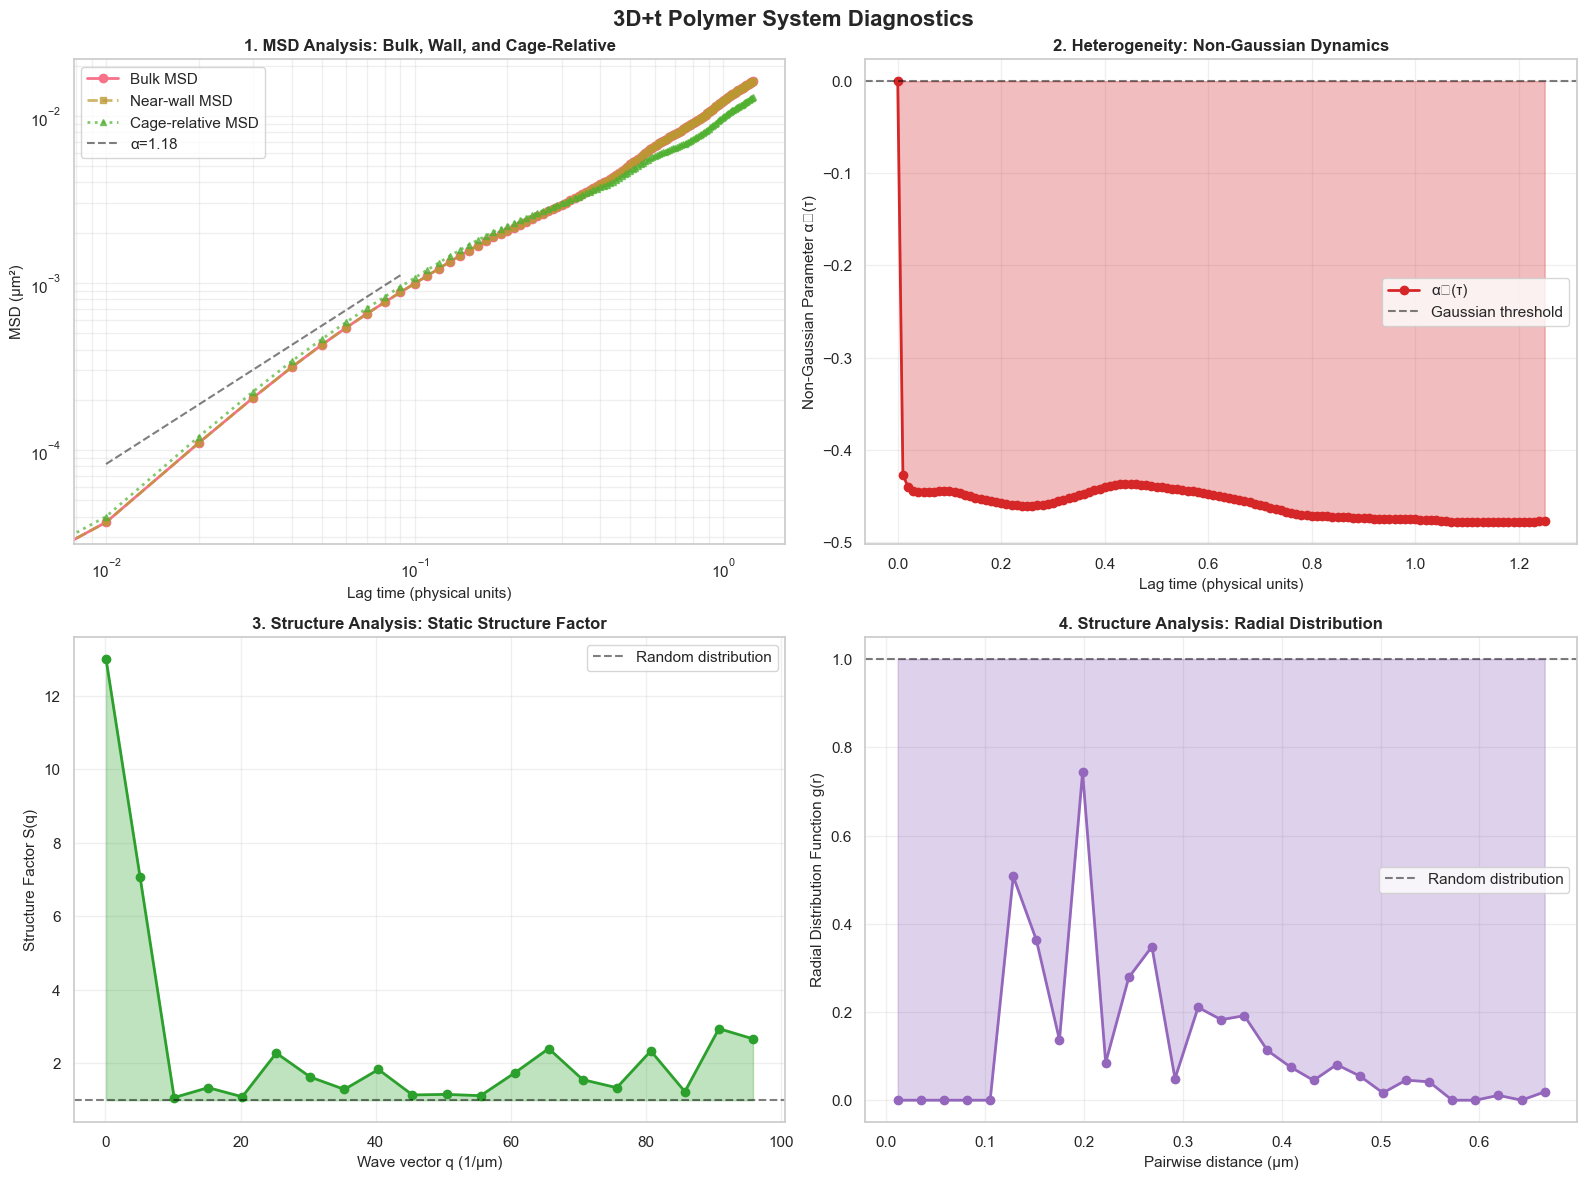

In [81]:
def plot_diagnostics(analyzer: PhysicsAnalyst, 
                    trajectories: List[Trajectory],
                    summary: Dict,
                    title: str = "Physics Diagnostics"):
    """
    Create comprehensive visualization of all four diagnostic modules.
    """
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle(title, fontsize=16, fontweight='bold')
    
    # ====== Panel 1: Bulk + Wall + Cage MSD ======
    ax = axes[0, 0]
    
    bulk = summary['msd_analysis']['bulk']
    wall = summary['msd_analysis']['near_wall']
    cage = summary['msd_analysis']['cage_relative']
    
    ax.loglog(bulk['lag_times'], bulk['msd_values'], 'o-', label='Bulk MSD', linewidth=2, markersize=6)
    ax.loglog(wall['lag_times'], wall['msd_wall'], 's--', label='Near-wall MSD', linewidth=2, markersize=5, alpha=0.7)
    ax.loglog(cage['lag_times'], cage['msd_cage'], '^:', label='Cage-relative MSD', linewidth=2, markersize=5, alpha=0.7)
    
    # Overlay power law fit
    alpha = bulk['anomaly_exponent_alpha']
    tau_fit = np.array(bulk['lag_times'])[1:10]
    msd_fit = tau_fit ** alpha * (bulk['msd_values'][5] / (tau_fit[3]**alpha))
    ax.loglog(tau_fit, msd_fit, 'k--', alpha=0.5, label=f"α={alpha:.2f}")
    
    ax.set_xlabel('Lag time (physical units)', fontsize=11)
    ax.set_ylabel('MSD (μm²)', fontsize=11)
    ax.set_title('1. MSD Analysis: Bulk, Wall, and Cage-Relative', fontsize=12, fontweight='bold')
    ax.legend(loc='best')
    ax.grid(True, which='both', alpha=0.3)
    
    # ====== Panel 2: Non-Gaussian Parameter α₂(τ) ======
    ax = axes[0, 1]
    
    lag_times_het, alpha2_array = analyzer.compute_non_gaussian_parameter(trajectories)
    
    ax.plot(lag_times_het, alpha2_array, 'o-', color='tab:red', linewidth=2, markersize=6, label='α₂(τ)')
    ax.axhline(y=0, color='k', linestyle='--', alpha=0.5, label='Gaussian threshold')
    ax.fill_between(lag_times_het, 0, alpha2_array, alpha=0.3, color='tab:red')
    
    hetero = summary['heterogeneity']
    if hetero['alpha2_max']:
        ax.plot(hetero['alpha2_tau_peak'], hetero['alpha2_max'], 'r*', markersize=20, 
               label=f"Peak α₂={hetero['alpha2_max']:.3f}")
    
    ax.set_xlabel('Lag time (physical units)', fontsize=11)
    ax.set_ylabel('Non-Gaussian Parameter α₂(τ)', fontsize=11)
    ax.set_title('2. Heterogeneity: Non-Gaussian Dynamics', fontsize=12, fontweight='bold')
    ax.legend(loc='best')
    ax.grid(True, alpha=0.3)
    
    # ====== Panel 3: Structure Factor S(q) ======
    ax = axes[1, 0]
    
    struct = summary['structure']
    ax.plot(struct['q_values'], struct['structure_factor'], 'o-', color='tab:green', linewidth=2, markersize=6)
    ax.axhline(y=1, color='k', linestyle='--', alpha=0.5, label='Random distribution')
    ax.fill_between(struct['q_values'], 1, struct['structure_factor'], alpha=0.3, color='tab:green')
    
    ax.set_xlabel('Wave vector q (1/μm)', fontsize=11)
    ax.set_ylabel('Structure Factor S(q)', fontsize=11)
    ax.set_title('3. Structure Analysis: Static Structure Factor', fontsize=12, fontweight='bold')
    ax.legend(loc='best')
    ax.grid(True, alpha=0.3)
    
    # ====== Panel 4: Pair Correlation g(r) ======
    ax = axes[1, 1]
    
    if struct['pair_correlation'] and struct['distances']:
        ax.plot(struct['distances'], struct['pair_correlation'], 'o-', color='tab:purple', linewidth=2, markersize=6)
        ax.axhline(y=1, color='k', linestyle='--', alpha=0.5, label='Random distribution')
        ax.fill_between(struct['distances'], 1, struct['pair_correlation'], alpha=0.3, color='tab:purple')
        
        ax.set_xlabel('Pairwise distance (μm)', fontsize=11)
        ax.set_ylabel('Radial Distribution Function g(r)', fontsize=11)
    else:
        ax.text(0.5, 0.5, "Insufficient data for g(r)", ha='center', va='center', fontsize=12)
    
    ax.set_title('4. Structure Analysis: Radial Distribution', fontsize=12, fontweight='bold')
    ax.legend(loc='best')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig


# Plot all three examples
fig_colloidal = plot_diagnostics(
    analyzer_colloidal, trajectories_colloidal, summary_colloidal,
    title="Colloidal System Diagnostics"
)

fig_cellular_3d = plot_diagnostics(
    analyzer_cellular_3d, trajectories_cellular_3d, summary_cellular_3d,
    title="3D+t Cellular System Diagnostics"
)

fig_polymer_3d = plot_diagnostics(
    analyzer_polymer_3d, trajectories_polymer_3d, summary_polymer_3d,
    title="3D+t Polymer System Diagnostics"
)



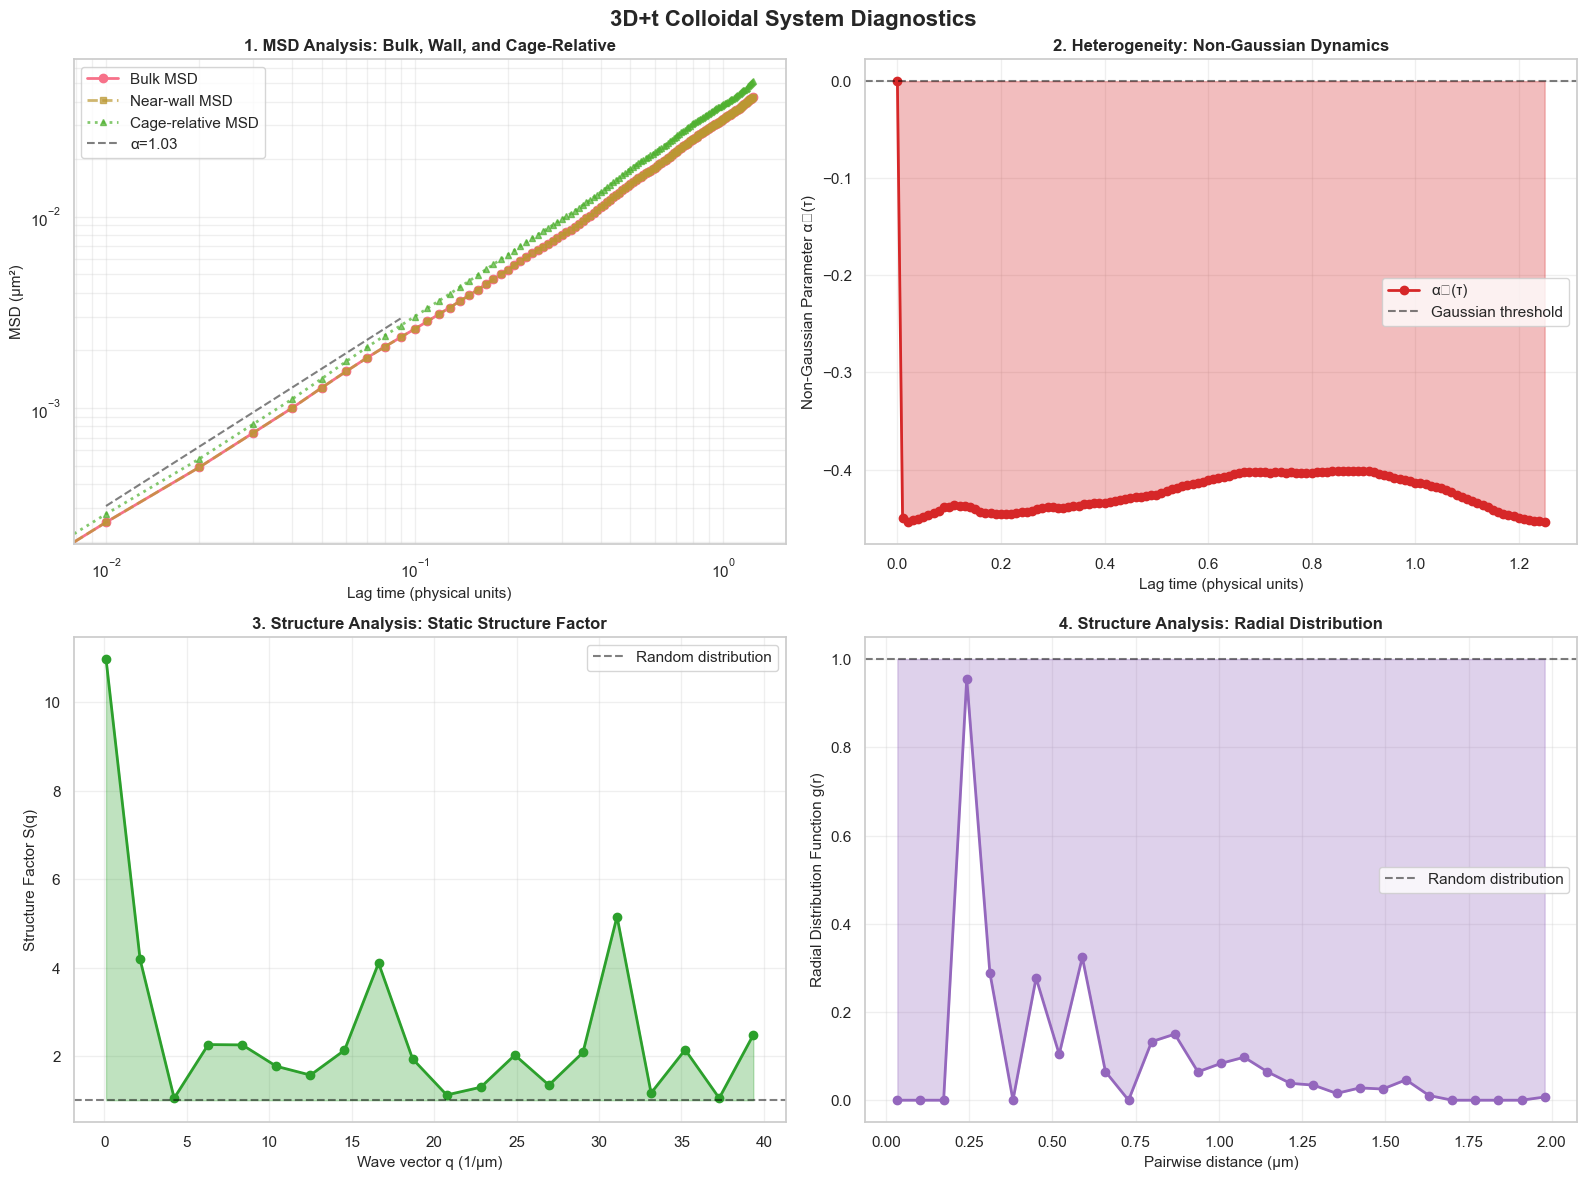

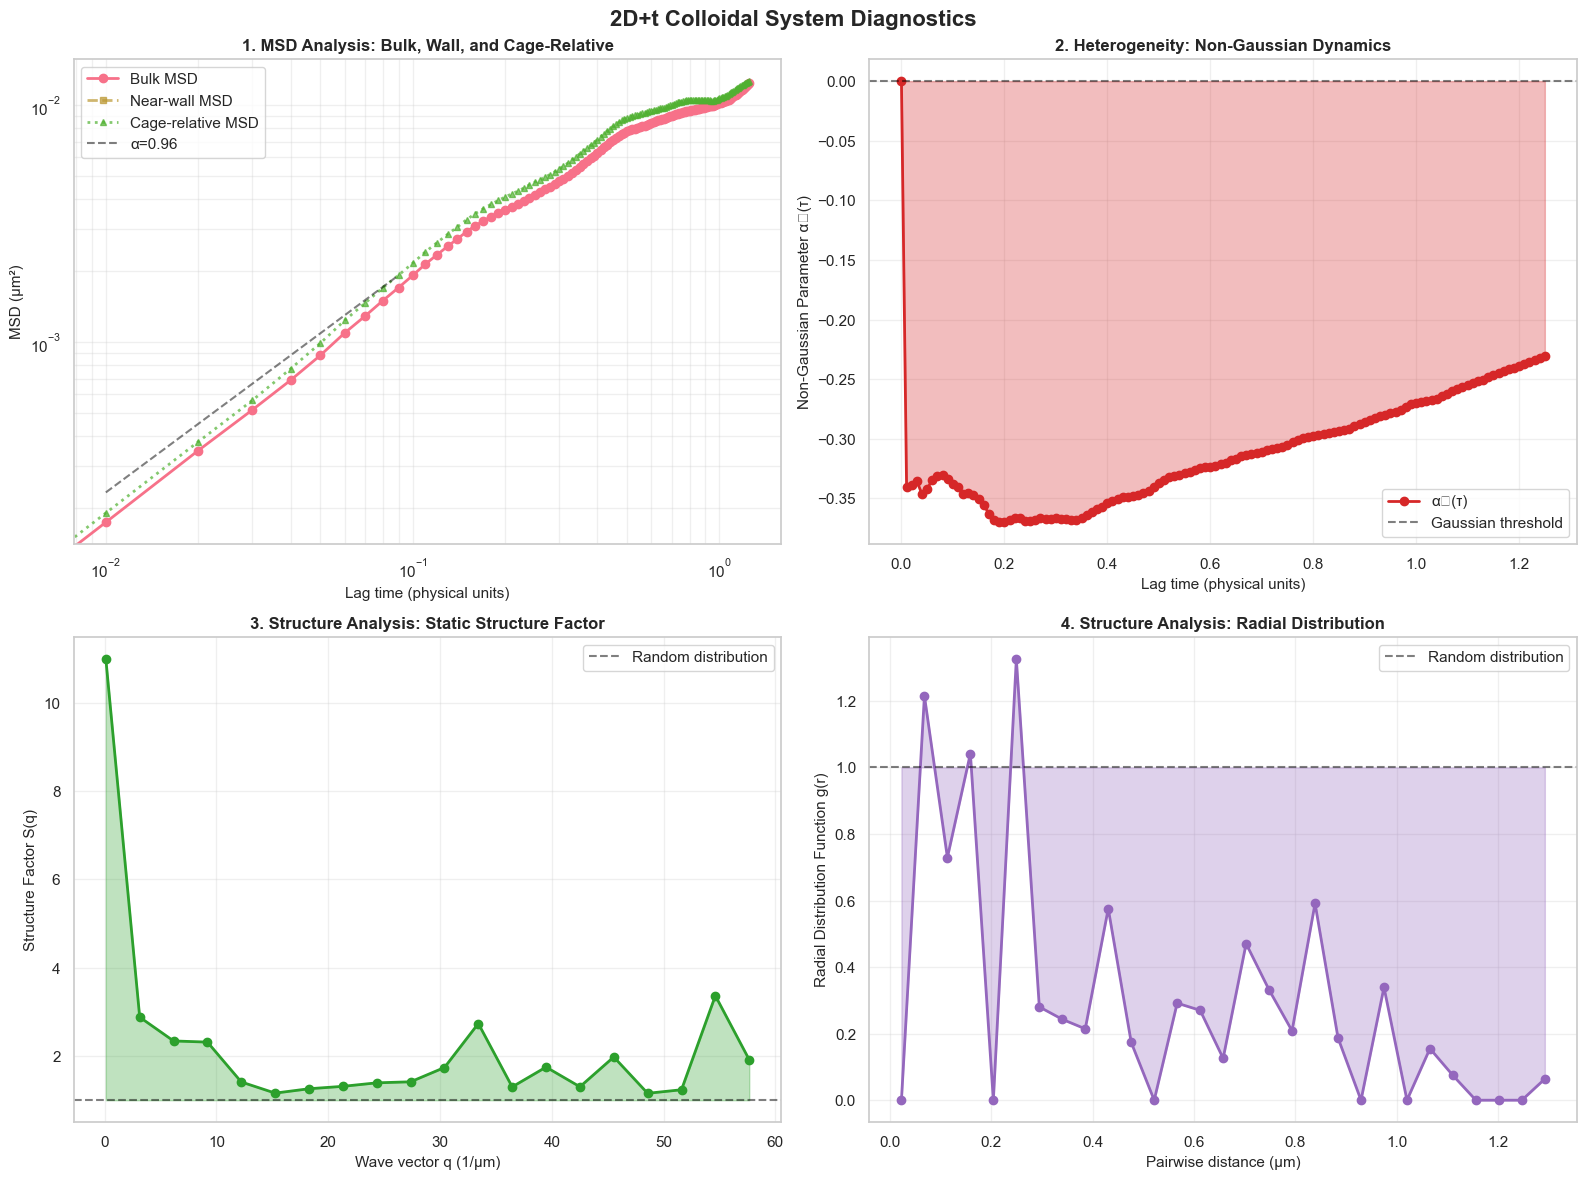

In [82]:
fig_colloidal_3d = plot_diagnostics(
    analyzer_colloidal_3d, trajectories_colloidal_3d, summary_colloidal_3d,
    title="3D+t Colloidal System Diagnostics"
)

fig_colloidal_2d = plot_diagnostics(
    analyzer_colloidal_2d, trajectories_colloidal_2d, summary_colloidal_2d,
    title="2D+t Colloidal System Diagnostics"
)

## Section 7: JSON Export for LLM Integration

Save summaries as JSON files ready for use by ChatGPT/Gemini.

In [83]:
import json
from pathlib import Path
import numpy as np

def numpy_to_native(obj):
    if isinstance(obj, np.bool_):
        return bool(obj)
    if isinstance(obj, np.integer):
        return int(obj)
    if isinstance(obj, np.floating):
        return float(obj)
    return obj

output_dir = Path("physics_summaries")
output_dir.mkdir(exist_ok=True)

# Dynamic 3D+t and 2D+t summaries
summaries = {
    "colloidal_3d_t": summary_colloidal_3d,
    "cellular_3d_t": summary_cellular_3d,
    "polymer_3d_t": summary_polymer_3d,
    "colloidal_2d_t": summary_colloidal_2d,
    "cellular_2d_t": summary_cellular_2d,
}

for name, summary in summaries.items():
    output_file = output_dir / f"{name}_summary.json"
    with open(output_file, "w") as f:
        json.dump(summary, f, indent=2, default=numpy_to_native)
    print(f"Saved {output_file}")

print(f"\nAll dynamic summaries saved to {output_dir}/")

# Snapshot-only structures (2D, 3D)
snapshot_struct = {
    "snapshot_2d": struct_2d.to_dict(),
    "snapshot_3d": struct_3d.to_dict(),
}
snap_file = output_dir / "snapshots_structure_only.json"
with open(snap_file, "w") as f:
    json.dump(snapshot_struct, f, indent=2, default=numpy_to_native)
print(f"Saved {snap_file}")


Saved physics_summaries\colloidal_3d_t_summary.json
Saved physics_summaries\cellular_3d_t_summary.json
Saved physics_summaries\polymer_3d_t_summary.json
Saved physics_summaries\colloidal_2d_t_summary.json
Saved physics_summaries\cellular_2d_t_summary.json

All dynamic summaries saved to physics_summaries/
Saved physics_summaries\snapshots_structure_only.json


## Section 8: LLM-Ready Summary Format

Example prompt for ChatGPT/Gemini that uses the JSON summary.

In [85]:
import numpy as np

def numpy_to_native(obj):
    if isinstance(obj, np.bool_):
        return bool(obj)
    if isinstance(obj, np.integer):
        return int(obj)
    if isinstance(obj, np.floating):
        return float(obj)
    return obj


In [88]:
import json
import numpy as np

def numpy_to_native(obj):
    if isinstance(obj, np.bool_):
        return bool(obj)
    if isinstance(obj, np.integer):
        return int(obj)
    if isinstance(obj, np.floating):
        return float(obj)
    return obj


def create_llm_prompt(summary: dict, domain: str = "general") -> str:
    meta = summary.get("metadata", {})
    msd = summary.get("msd_analysis", {})
    bulk = msd.get("bulk", {})
    near_wall = msd.get("near_wall", {})
    cage = msd.get("cage_relative", {})
    hetero = summary.get("heterogeneity", {})
    struct = summary.get("structure", {})
    flags = summary.get("flags_and_anomalies", [])

    prompt = (
        "You are a physics-aware assistant analyzing particle tracking data.\n\n"
        "The user has provided a pre-computed physics summary from a `PhysicsAnalyst` pipeline.\n"
        "Your task is to interpret the dynamics, heterogeneity, and structure in clear language,\n"
        "and optionally suggest follow-up experiments or checks.\n\n"
        "---\n\n"
        "### 1. Dataset Metadata\n\n"
        f"- Domain: {meta.get('domain', domain)}\n"
        f"- Number of trajectories: {meta.get('n_trajectories', 'N/A')}\n"
        f"- Mean trajectory length (frames): {meta.get('mean_trajectory_length', 'N/A')}\n"
        f"- dt (physical units): {meta.get('dt_physical_units', 'N/A')}\n"
        f"- px_to_um conversion: {meta.get('pxtoum_conversion', 'N/A')}\n\n"
        "### 2. Bulk MSD (Global Dynamics)\n\n"
        f"- Anomaly exponent α (bulk): {bulk.get('anomaly_exponent_alpha', 'N/A')}\n"
        f"- Diffusion coefficient (bulk): {bulk.get('diffusion_coefficient', 'N/A')}\n"
        f"- Bulk interpretation: {bulk.get('interpretation', 'N/A')}\n"
    )

    if near_wall.get("lag_times"):
        prompt += (
            "\n### 3. Near-Wall MSD\n\n"
            f"- Wall hindrance ratio (mean): {near_wall.get('wall_hindrance_ratio', 'N/A')}\n"
            f"- Anomaly exponent α (near wall): {near_wall.get('anomaly_exponent_wall', 'N/A')}\n\n"
            "Interpret the difference between bulk and near-wall MSD in terms of wall-induced hindrance\n"
            "(e.g., reduced mobility near surfaces, depletion layers, or confinement).\n"
        )

    if cage.get("lag_times"):
        prompt += (
            "\n### 4. Cage-Relative MSD\n\n"
            f"- Anomaly exponent α (cage-relative): {cage.get('anomaly_exponent_cage', 'N/A')}\n\n"
            "Discuss whether cage-relative dynamics differ from bulk MSD and what that implies\n"
            "about local rearrangements vs. affine motion (e.g., glassy dynamics, jamming, domains).\n"
        )

    prompt += (
        "\n### 5. Heterogeneity Metrics\n\n"
        f"- α₂ max (non-Gaussian parameter): {hetero.get('alpha2_max', 'N/A')}\n"
        f"- Lag time at α₂ peak: {hetero.get('alpha2_tau_peak', 'N/A')}\n"
        f"- MSD distribution mean (longest lag): {hetero.get('msd_distribution_mean', 'N/A')}\n"
        f"- MSD distribution std (longest lag): {hetero.get('msd_distribution_std', 'N/A')}\n"
        f"- Subdiffusion detected: {hetero.get('subdiffusion_detected', 'N/A')}\n"
        f"- Superdiffusion detected: {hetero.get('superdiffusion_detected', 'N/A')}\n"
        f"- Dynamic susceptibility (variance/mean proxy): {hetero.get('dynamicsusceptibility', 'N/A')}\n\n"
        "Explain whether dynamics are homogeneous or heterogeneous across particles,\n"
        "and relate α₂ and dynamic susceptibility to dynamic heterogeneity and rare events.\n"
    )

    prompt += (
        "\n### 6. Structure and Clustering\n\n"
        f"- Density estimate: {struct.get('density', 'N/A')}\n"
        f"- Clustering detected (S(0) >> 1): {struct.get('clustering_detected', 'N/A')}\n\n"
        "Discuss whether the system is clustered, uniform, or exhibits long-range correlations,\n"
        "based on S(q) and g(r). If clustering is detected, speculate on its origin.\n"
    )

    prompt += "\n### 7. Flags and Anomalies\n\n"
    if flags:
        for f in flags:
            prompt += f"- {f}\n"
    else:
        prompt += "- No strong anomalies detected.\n"

    prompt += "\n\n### 8. Domain-Specific Hints\n\n"
    if domain == "colloidal":
        prompt += (
            "Consider interpreting subdiffusion and clustering in terms of crowding, "
            "gelation, or attractive interactions (depletion, van der Waals, etc.).\n"
        )
    elif domain == "cellular":
        prompt += (
            "Relate sub/superdiffusion to viscoelastic cytoplasm, active transport, "
            "organelle crowding, and compartmentalization.\n"
        )
    elif domain == "polymer":
        prompt += (
            "Connect subdiffusion and non-Gaussian dynamics to polymer chain constraints, "
            "entanglements, and viscoelastic relaxation.\n"
        )
    else:
        prompt += (
            "Use general soft-matter language: viscoelasticity, crowding, confinement, "
            "and active driving as needed.\n"
        )

    prompt += (
        "\n### 9. JSON Summary (for programmatic use)\n\n"
        "JSON_START\n"
        f"{json.dumps(summary, indent=2, default=numpy_to_native)}\n"
        "JSON_END\n"
    )

    return prompt


In [89]:
print("\n" + "="*70)
print("LLM PROMPT FOR 3D+t COLLOIDAL SYSTEM")
print("="*70)
prompt_colloidal_3d = create_llm_prompt(summary_colloidal_3d, domain="colloidal")
print(prompt_colloidal_3d[:1000])

print("\n" + "="*70)
print("LLM PROMPT FOR 2D+t COLLOIDAL SYSTEM")
print("="*70)
prompt_colloidal_2d = create_llm_prompt(summary_colloidal_2d, domain="colloidal")
print(prompt_colloidal_2d[:1000])



LLM PROMPT FOR 3D+t COLLOIDAL SYSTEM
You are a physics-aware assistant analyzing particle tracking data.

The user has provided a pre-computed physics summary from a `PhysicsAnalyst` pipeline.
Your task is to interpret the dynamics, heterogeneity, and structure in clear language,
and optionally suggest follow-up experiments or checks.

---

### 1. Dataset Metadata

- Domain: colloidal
- Number of trajectories: 10
- Mean trajectory length (frames): 500.0
- dt (physical units): 0.01
- px_to_um conversion: N/A

### 2. Bulk MSD (Global Dynamics)

- Anomaly exponent α (bulk): 1.0274549435102969
- Diffusion coefficient (bulk): 0.004608046242048099
- Bulk interpretation: Brownian diffusion (normal)

### 3. Near-Wall MSD

- Wall hindrance ratio (mean): 0.0
- Anomaly exponent α (near wall): 1.0274549435102969

Interpret the difference between bulk and near-wall MSD in terms of wall-induced hindrance
(e.g., reduced mobility near surfaces, depletion layers, or confinement).

### 4. Cage-Relative